Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [245]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [246]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [247]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [248]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [249]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.metrics import mean_absolute_error

In [250]:
df = df[df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS']

In [251]:
df = df[((df['SALE_PRICE']>=100000) & (df['SALE_PRICE']<=2000000))]

In [252]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('04/01/2019')
train = df[df['SALE_DATE']<cutoff]
test = df[df['SALE_DATE']>=cutoff]

In [253]:
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',','')
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'])

In [254]:
df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
BOROUGH,3164,5,4,1585,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NEIGHBORHOOD,3164,6,OTHER,3001,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BUILDING_CLASS_CATEGORY,3164,1,01 ONE FAMILY DWELLINGS,3164,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TAX_CLASS_AT_PRESENT,3164,2,1,3123,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BLOCK,3164,NaN,NaN,NaN,NaT,NaT,6908.6,3964.33,21,4003.25,6269.5,10206.2,16350
LOT,3164,NaN,NaN,NaN,NaT,NaT,75.847,160.779,1,21,42,69,2720
EASE-MENT,0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BUILDING_CLASS_AT_PRESENT,3164,13,A1,1188,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADDRESS,3164,3148,108-16 171ST PLACE,2,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [255]:
target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE','BUILDING_CLASS_AT_TIME_OF_SALE',
                    'BUILDING_CLASS_AT_PRESENT']
features = train.columns.drop([target]+high_cardinality)

In [256]:
X_train.shape, X_test.shape

((2517, 32), (647, 32))

In [257]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [258]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [259]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

testing = []
training = []
ks = range(1, len(X_train.columns)+1)
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    # build selector
    selector = SelectKBest(k=k)
    X_train_selected = selector.fit_transform(X_train,y_train)
    X_test_selected = selector.transform(X_test)
    
    # build training model.
    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # predict with training data
    y_pred = model.predict(X_train_selected)
    # mae of train set
    mae = mean_absolute_error(y_train, y_pred)
    training.append(mae)
   
    # predict with test data
    y_pred = model.predict(X_test_selected)
    # mae of test set
    mae = mean_absolute_error(y_test, y_pred)
    testing.append(mae)
    print(f'Test Mean Absolute Error: ${mae:,.0f}\n')

1 features
Test Mean Absolute Error: $214,247

2 features
Test Mean Absolute Error: $214,244

3 features
Test Mean Absolute Error: $214,756

4 features
Test Mean Absolute Error: $209,822

5 features
Test Mean Absolute Error: $208,017

6 features
Test Mean Absolute Error: $207,518

7 features
Test Mean Absolute Error: $183,519

8 features
Test Mean Absolute Error: $183,190

9 features
Test Mean Absolute Error: $179,517

10 features
Test Mean Absolute Error: $179,695

11 features
Test Mean Absolute Error: $174,789

12 features
Test Mean Absolute Error: $175,442

13 features
Test Mean Absolute Error: $175,442

14 features
Test Mean Absolute Error: $175,377

15 features
Test Mean Absolute Error: $175,349

16 features
Test Mean Absolute Error: $175,334

17 features
Test Mean Absolute Error: $175,065

18 features
Test Mean Absolute Error: $175,224

19 features
Test Mean Absolute Error: $175,497

20 features
Test Mean Absolute Error: $175,713

21 features
Test Mean Absolute Error: $176,455

2

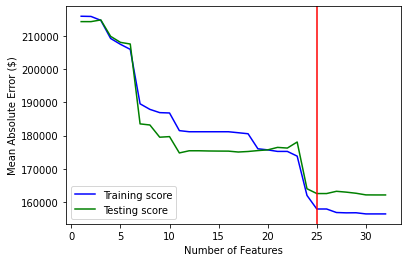

In [262]:
plt.plot(ks, training, label ='Training score', color='b')
plt.plot(ks, testing, label='Testing score', color='g')
plt.ylabel('Mean Absolute Error ($)')
plt.xlabel('Number of Features')
plt.axvline(x=25, color='r')
plt.legend()
plt.show()

In [263]:
for alpha in [0.0001,0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_pred,y_test)
    print(f'MAE = {mae}, with alpha of {alpha}\n')

MAE = 162326.94966290312, with alpha of 0.0001

MAE = 162260.41793391126, with alpha of 0.001

MAE = 161913.7283037486, with alpha of 0.01

MAE = 161907.36833313454, with alpha of 0.1

MAE = 175753.0670973893, with alpha of 1.0

MAE = 175753.0670973893, with alpha of 1

MAE = 212982.4645428687, with alpha of 100.0

MAE = 214151.8506526962, with alpha of 1000.0



In [264]:
from sklearn.linear_model import RidgeCV

alpha = [0.0001,0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]

ridge = RidgeCV(alphas=alpha, normalize=True)
ridge.fit(X_train_selected, y_train)
ridge.alpha_

0.001